# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import scipy

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Read updated *Nikos* data

In [2]:
xls = pd.ExcelFile('data/edited_nikos_data.xlsx')
xls.sheet_names

['ANAMET',
 'Anamet data',
 'ISRI',
 'Isri data',
 'UNS data',
 'Elements data',
 'Material data',
 'Process']

In [3]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

In [4]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [5]:
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN


In [6]:
uns_data.head(2)

,uns id,sc:hasName,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:UNS_712,C83300,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb
1,sc:UNS_733,C84500,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb


# Create `df` using `anamet` and `isri`

Προσπάθεια classifiaction ενός δοθέντος scap σε anamet / isri δεδομένου ενός description

### Raw data preprocessing

#### `ISRI`

In [7]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [8]:
isri_data.shape

(244, 10)

In [9]:
isri_data = isri_data[['isri id', 'sc:hasCategory', 'sc:hasForm', 'sc:hasSpecification', 'sc:contains', 'pc:hasName']]

In [10]:
isri_data.isna().sum()

isri id                 0
sc:hasCategory          0
sc:hasForm             43
sc:hasSpecification    12
sc:contains            68
pc:hasName              7
dtype: int64

In [11]:
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

for col in isri_data.drop('isri id', axis=1).columns:
    isri_data[col] = hero.clean(isri_data[col])

isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire
1,sc:ISRI_1,nonferrous scrap red metals,wire cable,clean untinned uncoated unalloyed,copper,copper wire


In [12]:
isri_data.isna().sum()

isri id                0
sc:hasCategory         0
sc:hasForm             0
sc:hasSpecification    0
sc:contains            0
pc:hasName             0
dtype: int64

#### `ANAMET`

In [13]:
anamet_data.head()

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN
2,sc:ANAMET_439,κουτάκι,Ferrous,9101,NaN
3,sc:ANAMET_440,λαμαρίνες,Ferrous,9102,NaN
4,sc:ANAMET_441,ζάντες + βαρύ προς shredder κλπ από ΟΤΚΖ,Ferrous,9103,NaN


In [14]:
anamet_data.shape

(322, 5)

Keep only ANAMET with english `sc:description`

In [15]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous,40014,NaN
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous,40015,NaN


In [16]:
anamet_data.shape

(214, 5)

In [17]:
anamet_data = anamet_data[['anamet entity', 'sc:description', 'sc:hasCategory']]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous


In [18]:
anamet_data.isna().sum()

anamet entity     0
sc:description    0
sc:hasCategory    0
dtype: int64

In [19]:
for col in anamet_data.drop('anamet entity', axis=1).columns:
    anamet_data[col] = hero.clean(anamet_data[col])

anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous
30,sc:ANAMET_466,copper scrap birch cables stripping,non ferrous


# Combine both datasets

Will combine `ISRI` and `ANAMET` dataframes into one.

In [20]:
df = pd.DataFrame()

In [21]:
isri_data.head(1)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire


In [22]:
anamet_data.head(1)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous


In [23]:
isri_data['corpus'] = isri_data['sc:hasSpecification'] + ' ' + isri_data['sc:hasForm'] + ' '  + isri_data['sc:contains'] + ' ' + isri_data['sc:hasCategory'] + ' '+ isri_data['pc:hasName']
isri_data = isri_data[['isri id', 'corpus']]
isri_data.head(1)

,isri id,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...


In [24]:
anamet_data['corpus'] = anamet_data['sc:description'] + ' ' + anamet_data['sc:hasCategory']
anamet_data = anamet_data[['anamet entity', 'corpus']]
anamet_data.head(1)

,anamet entity,corpus
28,sc:ANAMET_465,copper scrap millberry cables strip non ferrous


In [25]:
isri_data.rename(columns = {'isri id':'scrap_type'}, inplace = True)
anamet_data.rename(columns= {'anamet entity':'scrap_type'}, inplace = True)

Concat the dfs

In [26]:
df = pd.concat([isri_data, anamet_data], axis=0)
df

,scrap_type,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable c...
2,sc:ISRI_2,unalloyed miscellaneous wire copper nonferrous...
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...
4,sc:ISRI_4,unalloyed miscellaneous scrap copper nonferrou...
...,...,...
317,sc:ANAMET_684,lead scrap e non ferrous
318,sc:ANAMET_685,electric motors shredded weee non ferrous
319,sc:ANAMET_686,black plastic scrap weee e non ferrous
320,sc:ANAMET_687,scrap plexiglass e non ferrous


In [27]:
print( isri_data['scrap_type'].nunique() )
print( anamet_data['scrap_type'].nunique() )
print( df['scrap_type'].nunique() )

244
214
458


Every row is a different scrap type.

### Vectorize `corpus` using TF-IDF

In [28]:
vectorizer = TfidfVectorizer(min_df=20)
# vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['corpus'])                             
X

<458x48 sparse matrix of type '<class 'numpy.float64'>'
	with 2707 stored elements in Compressed Sparse Row format>

### Find optimal k for KMeans

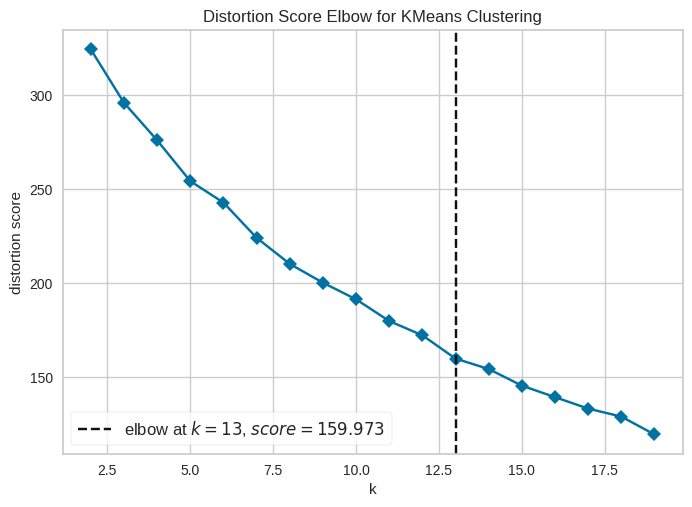

KElbowVisualizer(ax=<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19, random_state=1), k=(2, 20),
                 timings=False)

In [29]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=1),
                  np.asarray(X.todense()),
                  k=(2, 20),
                  timings=False)

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [31]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
include,iron,electric,mixed,material,brass,plastic,scrap,ferrous,non

Cluster 1
cast,clean,brass,copper,scrap,aluminum,ferrous,non,per,isri

Cluster 2
include,zinc,copper,mixed,scrap,electric,plastic,ferrous,non,weee

Cluster 3
lead,contain,copper,clean,scrap,turnings,nonferrous,metals,red,brass

Cluster 4
electric,include,casting,iron,furnace,stainless,foundry,ferrous,scrap,steel

Cluster 5
clean,turnings,scrap,clippings,new,nonferrous,sheet,stainless,solids,nickel

Cluster 6
content,clean,material,ferrous,new,nonferrous,non,scrap,cast,zinc

Cluster 7
ferrous,clean,consumer,meet,processed,requirements,specially,iron,grades,cast

Cluster 8
nonferrous,aluminum,red,metals,ferrous,steel,copper,percent,scrap,wire

Cluster 9
may,clean,content,plastic,copper,nonferrous,ferrous,scrap,non,lead

Cluster 10
contain,free,new,material,clean,ferrous,nonferrous,non,scrap,aluminum

Cluster 11
content,brass,per,nickel,new,mixed,scrap,ferrous,non,copper

Cluster 12
contain,shall,consist,iron

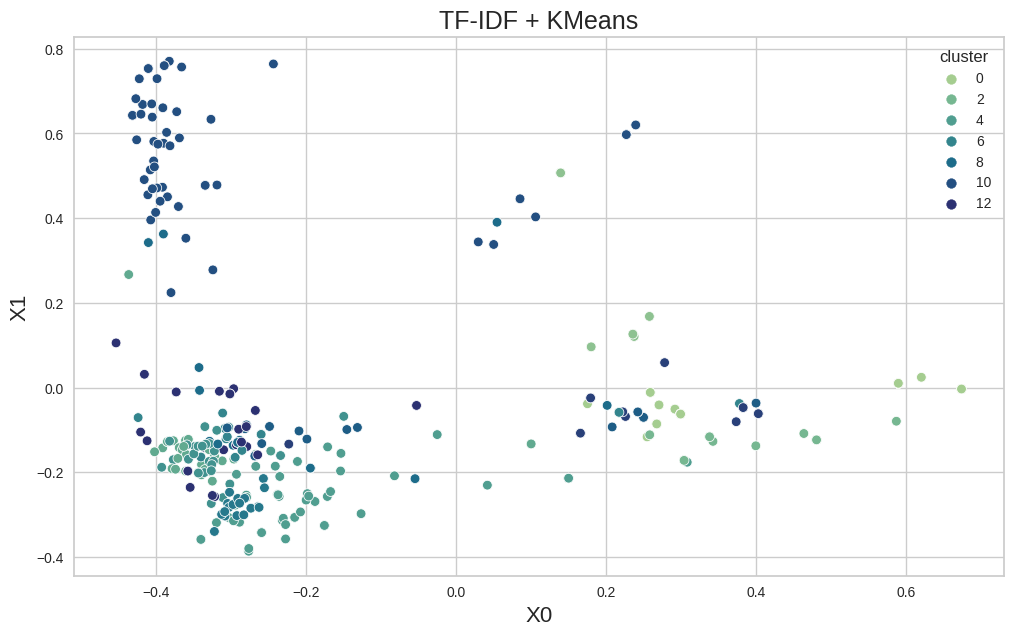

In [32]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="crest")
plt.show()

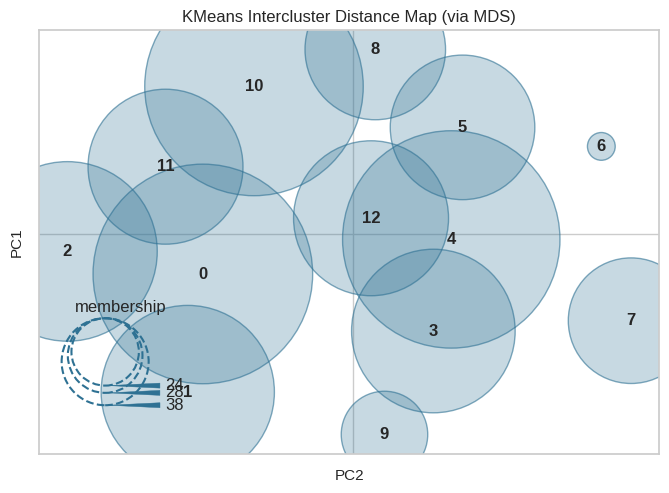

InterclusterDistance(ax=<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=13, random_state=42),
                     random_state=12)

In [33]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(kmeans, 
                      X.todense(), 
                      embedding='mds', 
                      random_state=12) # other option for embedding 'tsne'

In [34]:
df[['scrap_type', 'corpus', 'cluster']]

,scrap_type,corpus,cluster
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...,8
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable c...,8
2,sc:ISRI_2,unalloyed miscellaneous wire copper nonferrous...,8
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...,12
4,sc:ISRI_4,unalloyed miscellaneous scrap copper nonferrou...,12
...,...,...,...
317,sc:ANAMET_684,lead scrap e non ferrous,9
318,sc:ANAMET_685,electric motors shredded weee non ferrous,2
319,sc:ANAMET_686,black plastic scrap weee e non ferrous,2
320,sc:ANAMET_687,scrap plexiglass e non ferrous,0


In [35]:
for cluster in range(0, 13): print("Cluster", cluster, ":", len(df[df['cluster'] == cluster]))

Cluster 0 : 66
Cluster 1 : 35
Cluster 2 : 38
Cluster 3 : 31
Cluster 4 : 64
Cluster 5 : 25
Cluster 6 : 16
Cluster 7 : 21
Cluster 8 : 24
Cluster 9 : 17
Cluster 10 : 65
Cluster 11 : 28
Cluster 12 : 28


In [36]:
df.drop(columns=['x0','x1'], inplace=True)
df.head(2)

,scrap_type,corpus,cluster
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...,8
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable c...,8


In [37]:
from sklearn.model_selection import train_test_split

# X = df['corpus']
X = df.drop('cluster', axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4, stratify=y)

vectorizer = TfidfVectorizer(min_df=20)

train_vectors = vectorizer.fit_transform(X_train['corpus'])
test_vectors = vectorizer.transform(X_test['corpus'])

print(train_vectors.shape, test_vectors.shape)

(320, 32) (138, 32)


In [38]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(train_vectors)
clusters = kmeans.labels_

In [39]:
y_train = clusters

In [40]:
y_test_predicted = kmeans.predict(test_vectors)

In [41]:
pd.DataFrame(y_train).value_counts(normalize=True)

2     0.156250
3     0.140625
7     0.103125
4     0.090625
10    0.081250
1     0.075000
11    0.075000
5     0.062500
8     0.056250
6     0.053125
9     0.043750
0     0.031250
12    0.031250
dtype: float64

In [42]:
pd.DataFrame(y_test_predicted).value_counts(normalize=True)

2     0.166667
3     0.152174
4     0.086957
7     0.086957
10    0.086957
11    0.086957
1     0.079710
6     0.065217
8     0.043478
0     0.036232
5     0.036232
9     0.036232
12    0.036232
dtype: float64

In [43]:
test = pd.DataFrame()

test['type'] = X_test['scrap_type']
test['corpus'] = X_test['corpus']
test['cluster'] = y_test_predicted

test

,type,corpus,cluster
96,sc:ISRI_96,incinerated burned material must dry contain x...,3
13,sc:ISRI_13,made copper tin zinc lead valves machinery bea...,7
70,sc:ANAMET_486,starters alternators raw non ferrous,2
62,sc:ISRI_62,clean chopped shredder must contain aluminum c...,3
55,sc:ISRI_55,food beverage cans cans aluminum nonferrous sc...,3
...,...,...,...
213,sc:ANAMET_580,copper coils weee non ferrous,10
156,sc:ISRI_156,shoud contain minimum tin tin based babbit no...,7
69,sc:ISRI_69,old unalloyed may contain series wire cable fr...,0
137,sc:ISRI_137,consist soldered brazed miscellaneous grades m...,8


In [44]:
X_train['cluster'] = y_train

In [45]:
X_train[X_train['cluster'] == 12].reset_index()

,index,scrap_type,corpus,cluster
0,103,sc:ISRI_103,new pure zinc contain foreign material attachm...,12
1,99,sc:ISRI_99,new unused clean zinc base die castings castin...,12
2,107,sc:ISRI_107,melted zinc base die cast materials smooth cle...,12
3,185,sc:ANAMET_552,zinc scrap zamak non ferrous,12
4,108,sc:ISRI_108,unsweated zinc dross removed top continuous li...,12
5,105,sc:ISRI_105,material contain zinc bearing scrap nonferrous...,12
6,110,sc:ISRI_110,metal skimmed top pot molten zinc die cast met...,12
7,109,sc:ISRI_109,unsweated zinc dross removed top continuous li...,12
8,100,sc:ISRI_100,clean old used foreign attachments extraneous ...,12
9,101,sc:ISRI_101,new unused clean plated zinc base die castings...,12


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


idx = 12

s = test['corpus'].iloc[idx]
c = test['cluster'].iloc[idx]
st = test['type'].iloc[idx]

similarity = []
index = []
similar_string = []
scrap_type = []
similarity_df = pd.DataFrame()

df_cluster = X_train[X_train['cluster'] == c]

for row in range(len(df_cluster)):
    s1 = df_cluster['corpus'].iloc[row]
    
    strings = [s, s1]
    str_sim = pd.DataFrame(data=strings)
    
    # vectorizer_sim = TfidfVectorizer()
    # strings_vectors = vectorizer_sim.fit_transform(str_sim[0])
    strings_vectors = vectorizer.transform(str_sim[0])
    
    csim = cosine_similarity(strings_vectors[0], strings_vectors[1])
    similarity.append(csim)
    index.append(row)
    similar_string.append(s1)
    scrap_type.append(df_cluster['scrap_type'].iloc[row])
    
similarity_df['csim'] = similarity
similarity_df['corpus'] = similar_string
similarity_df['scrap_type'] = scrap_type

similarity_df['csim'] = similarity_df['csim'].astype(float)
similarity_df['corpus'] = similarity_df['corpus'].astype(str)
similarity_df['scrap_type'] = similarity_df['scrap_type'].astype(str)

print(similarity_df['csim'].idxmax(), "\n", similarity_df['csim'].max(), '\n', similarity_df['corpus'].iloc[similarity_df['csim'].idxmax()], similarity_df['scrap_type'].iloc[similarity_df['csim'].idxmax()])

5 
 1.0000000000000002 
 copper clove per isri prod non ferrous sc:ANAMET_604


In [47]:
print(s, st)

copper cobra per isri production non ferrous sc:ANAMET_603


# Test set created from Internet 

In [48]:
s = ['Shredded demolition windows profiles | 5-20 cm, around 1% attachment of thermal break (plastic). Are not passed by X-ray treatment.',
     'Open Extinguisher with no heads | 6061 grade',
     'I sell structural steel oxycut both in skeleton (6 x 2.5 m. plates) and some cut parts. Hot-rolled non-alloy carbon steel cleaned of paints and greases. Dry product.',
     'Regulary purchase of galvalume dross, capacity 300-500mt/month',
     'With no cable, plate or grit. CuSN in cable, plate or grit, separately. Not mixed. In the case of small packaged (30x30 cm) and palletized cable, ball and shot in BIG BAGS',
     'Clean copper aluminum radiator without iron, the price may vary depending on the LME of the copper Lowest 3 months 7656€.']

df = pd.DataFrame()
df['corpus'] = s
df['corpus'] = hero.clean(df['corpus'])

X = df['corpus']

validation_vectors = vectorizer.transform(X)
print(validation_vectors.shape)

(6, 32)


In [65]:
df['cluster'] = kmeans.predict(validation_vectors)
idx = 5

for idx in range(0, 6):


    s = df['corpus'].iloc[idx]
    c = df['cluster'].iloc[idx]

    similarity = []
    index = []
    similar_string = []
    scrap_type = []
    similarity_df = pd.DataFrame()

    df_cluster = X_train[X_train['cluster'] == c]

    for row in range(len(df_cluster)):
        s1 = df_cluster['corpus'].iloc[row]

        strings = [s, s1]
        str_sim = pd.DataFrame(data=strings)

        # vectorizer_sim = TfidfVectorizer()
        # strings_vectors = vectorizer_sim.fit_transform(str_sim[0])
        strings_vectors = vectorizer.transform(str_sim[0])

        csim = cosine_similarity(strings_vectors[0], strings_vectors[1])
        similarity.append(csim)
        index.append(row)
        similar_string.append(s1)
        scrap_type.append(df_cluster['scrap_type'].iloc[row])

    similarity_df['csim'] = similarity
    similarity_df['corpus'] = similar_string
    similarity_df['scrap_type'] = scrap_type

    similarity_df['csim'] = similarity_df['csim'].astype(float)
    similarity_df['corpus'] = similarity_df['corpus'].astype(str)
    similarity_df['scrap_type'] = similarity_df['scrap_type'].astype(str)

    print(similarity_df['csim'].idxmax(), "\n", similarity_df['csim'].max(), '\n', similarity_df['corpus'].iloc[similarity_df['csim'].idxmax()], similarity_df['scrap_type'].iloc[similarity_df['csim'].idxmax()], '\n\n', s)

0 
 0.0 
 contain free iron oil moisture contain tin alloyed iron rod turnings strictly yellow brass nonferrous scrap red metals yellow brass rod turnings sc:ISRI_42 

 shredded demolition windows profiles cm around attachment thermal break plastic passed x ray treatment
0 
 0.0 
 contain free iron oil moisture contain tin alloyed iron rod turnings strictly yellow brass nonferrous scrap red metals yellow brass rod turnings sc:ISRI_42 

 open extinguisher heads grade
12 
 0.9000859514073011 
  turnings steel ferrous scrap briquetted steel turnings sc:ISRI_186 

 sell structural steel oxycut skeleton x plates cut parts hot rolled non alloy carbon steel cleaned paints greases dry product
0 
 0.0 
 contain free iron oil moisture contain tin alloyed iron rod turnings strictly yellow brass nonferrous scrap red metals yellow brass rod turnings sc:ISRI_42 

 regulary purchase galvalume dross capacity 500mt month
9 
 0.7011468909171875 
 semi pro mixed copper cables elv non ferrous sc:ANAMET_63